In [11]:
import jax.numpy as jnp
from models.variable_susceptibility import (
    simulate_variable_susceptibility_hom_final,
    simulate_variable_susceptibility_pol_final
)
from sweeps import run_susceptibility_sweep

def compare_single_point_sweep_vs_direct():
    """
    Compare sweep results with direct simulation for a single point.
    Uses same parameters for both to ensure they should give identical results.
    """
    # Common parameters
    susc_max = 0.4
    ab_val = 1.0
    h = 0
    dt = 0.25
    T = 1000
    recovery_rate = 0.1
    
    print("=== Testing single point simulation ===")
    print(f"Parameters:")
    print(f"max susceptibility: {susc_max}")
    print(f"a = b: {ab_val}")
    print(f"h: {h}")
    
    # Run sweep with just one point
    sweep_results = run_susceptibility_sweep(
        susc_min=susc_max,  # Same value for min and max to get single point
        susc_max=susc_max,
        n_susc=1,          # Just one point
        ab_min=ab_val,     # Same value for min and max
        ab_max=ab_val,
        n_ab=1,            # Just one point
        h=h,
        dt=dt,
        T=T,
        recovery_rate=recovery_rate
    )
    
    # Run direct simulation
    base_params = {
        'transmission_rates': (0.1, susc_max),
        'recovery_rate': recovery_rate,
        'dt': dt,
        'homophilic_tendency': h,
        'beta_params': (ab_val, ab_val)
    }
    
    sim_fn = simulate_variable_susceptibility_hom_final if h != 0 else simulate_variable_susceptibility_pol_final
    direct_results = sim_fn(
        beta_params=(ab_val, ab_val),
        params=base_params,
        n_steps=int(T/dt)
    )
    
    # Extract results
    S_sweep, I_sweep, R_sweep = sweep_results
    S_direct, I_direct, R_direct = direct_results
    
    # Compare results
    print("\nComparison of results:")
    print("Sweep shapes:", S_sweep.shape, I_sweep.shape, R_sweep.shape)
    print("Direct shapes:", S_direct.shape, I_direct.shape, R_direct.shape)
    
    print("\nAbsolute differences:")
    print(f"Max S diff: {abs(S_sweep - S_direct).max():.2e}")
    print(f"Max I diff: {abs(I_sweep - I_direct).max():.2e}")
    print(f"Max R diff: {abs(R_sweep - R_direct).max():.2e}")
    
    print("\nConservation check (S + I + R = 1):")
    print(f"Sweep max deviation: {abs(S_sweep + I_sweep + R_sweep - 1.0).max():.2e}")
    print(f"Direct max deviation: {abs(S_direct + I_direct + R_direct - 1.0).max():.2e}")

    return {
        'sweep': (S_sweep, I_sweep, R_sweep),
        'direct': (S_direct, I_direct, R_direct)
    }


In [13]:
import jax.numpy as jnp
from models.variable_susceptibility import (
    simulate_variable_susceptibility_hom_final,
    simulate_variable_susceptibility_pol_final
)
from sweeps import run_susceptibility_sweep

def compare_multi_point_sweep_vs_direct():
    """
    Compare sweep results with direct simulations for three susceptibility values.
    """
    # Common parameters
    susc_values = [0.2, 0.4, 0.6]
    ab_val = 1.0
    h = 2.0
    dt = 0.25
    T = 1000
    recovery_rate = 0.1
    
    print("=== Testing multi-point simulation ===")
    print(f"Parameters:")
    print(f"susceptibility values: {susc_values}")
    print(f"a = b: {ab_val}")
    print(f"h: {h}")
    
    # Run sweep
    sweep_results = run_susceptibility_sweep(
        susc_min=min(susc_values),
        susc_max=max(susc_values),
        n_susc=len(susc_values),  # 3 points
        ab_min=ab_val,
        ab_max=ab_val,
        n_ab=1,
        h=h,
        dt=dt,
        T=T,
        recovery_rate=recovery_rate
    )
    
    # Run direct simulations
    direct_results = []
    sim_fn = simulate_variable_susceptibility_hom_final if h != 0 else simulate_variable_susceptibility_pol_final
    
    for susc in susc_values:
        base_params = {
            'transmission_rates': (0.1, susc),
            'recovery_rate': recovery_rate,
            'dt': dt,
            'homophilic_tendency': h,
            'beta_params': (ab_val, ab_val)
        }
        
        result = sim_fn(
            beta_params=(ab_val, ab_val),
            params=base_params,
            n_steps=int(T/dt)
        )
        direct_results.append(result)
    
    # Extract results
    S_sweep, I_sweep, R_sweep = sweep_results
    
    # Compare results for each susceptibility value
    print("\nDetailed comparison for each susceptibility value:")
    for idx, susc in enumerate(susc_values):
        S_direct, I_direct, R_direct = direct_results[idx]
        
        print(f"\n--- Susceptibility = {susc} ---")
        print(f"Sweep  S: {S_sweep[idx][:5]}")  # First 5 values
        print(f"Direct S: {S_direct[:5]}")
        print(f"Max differences:")
        print(f"S diff: {abs(S_sweep[idx] - S_direct).max():.2e}")
        print(f"I diff: {abs(I_sweep[idx] - I_direct).max():.2e}")
        print(f"R diff: {abs(R_sweep[idx] - R_direct).max():.2e}")
        
        # Conservation check
        sweep_sum = S_sweep[idx] + I_sweep[idx] + R_sweep[idx]
        direct_sum = S_direct + I_direct + R_direct
        print(f"Conservation check (deviation from 1.0):")
        print(f"Sweep : {abs(sweep_sum - 1.0).max():.2e}")
        print(f"Direct: {abs(direct_sum - 1.0).max():.2e}")
    
    return {
        'sweep': sweep_results,
        'direct': direct_results,
        'susc_values': susc_values
    }

def plot_comparison(results):
    """
    Create a simple plot comparing sweep and direct results.
    Assuming you have matplotlib available.
    """
    import matplotlib.pyplot as plt
    
    sweep_results = results['sweep']
    direct_results = results['direct']
    susc_values = results['susc_values']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    compartments = ['S', 'I', 'R']
    
    for idx, (ax, compartment) in enumerate(zip(axes, compartments)):
        for s_idx, susc in enumerate(susc_values):
            # Plot sweep results
            ax.plot(sweep_results[idx][s_idx], 
                   label=f'Sweep {susc}', 
                   linestyle='-')
            
            # Plot direct results
            ax.plot(direct_results[s_idx][idx], 
                   label=f'Direct {susc}', 
                   linestyle='--')
        
        ax.set_title(f'Compartment {compartment}')
        ax.set_xlabel('Population index')
        ax.set_ylabel('Fraction')
        ax.legend()
    
    plt.tight_layout()
    return fig

In [14]:
results = compare_multi_point_sweep_vs_direct()


=== Testing multi-point simulation ===
Parameters:
susceptibility values: [0.2, 0.4, 0.6]
a = b: 1.0
h: 2.0

Detailed comparison for each susceptibility value:

--- Susceptibility = 0.2 ---
Sweep  S: [0.00388313 0.00383079 0.0037817  0.00373571 0.00369271]
Direct S: [0.00388313 0.00383079 0.0037817  0.00373571 0.00369271]
Max differences:
S diff: 0.00e+00
I diff: 0.00e+00
R diff: 0.00e+00
Conservation check (deviation from 1.0):
Sweep : 9.90e-01
Direct: 9.90e-01

--- Susceptibility = 0.4 ---
Sweep  S: [0.00062517 0.00060507 0.000587   0.00057079 0.00055627]
Direct S: [0.00062517 0.00060507 0.000587   0.00057079 0.00055627]
Max differences:
S diff: 0.00e+00
I diff: 0.00e+00
R diff: 0.00e+00
Conservation check (deviation from 1.0):
Sweep : 9.90e-01
Direct: 9.90e-01

--- Susceptibility = 0.6 ---
Sweep  S: [1.16589355e-04 1.11011119e-04 1.06114130e-04 1.01821250e-04
 9.80672194e-05]
Direct S: [1.16589355e-04 1.11011119e-04 1.06114130e-04 1.01821250e-04
 9.80672194e-05]
Max differences:
S d

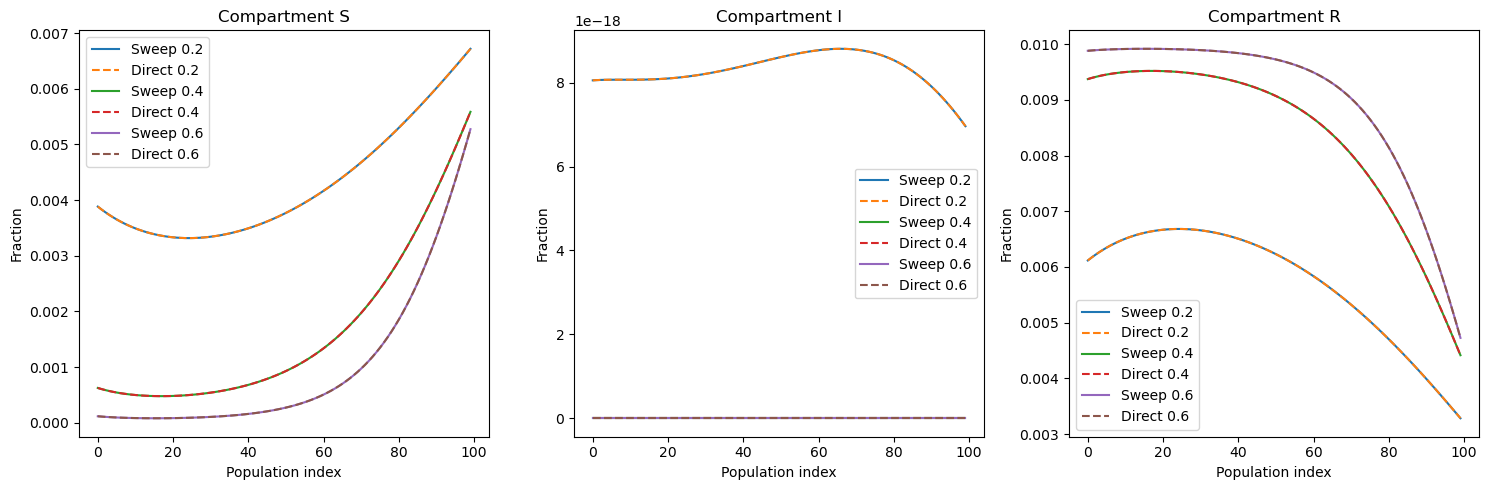

In [17]:
fig = plot_comparison(results)